Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\skopt\sampler\sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+25002=25002. 
  total_n_samples))


Compiling model...
Building feed-forward neural network...
'build' took 0.056420 s



C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\skopt\sampler\sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+3002=3002. 
  total_n_samples))
C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 3.655406 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [7.54e+01, 8.85e-01]    [7.54e+01, 8.85e-01]    []  
1000      [3.42e-01, 2.78e+00]    [3.42e-01, 2.78e+00]    []  
2000      [4.13e-01, 2.66e+00]    [4.13e-01, 2.66e+00]    []  
3000      [4.40e-01, 2.60e+00]    [4.40e-01, 2.60e+00]    []  
4000      [4.60e-01, 2.54e+00]    [4.60e-01, 2.54e+00]    []  
5000      [4.86e-01, 2.47e+00]    [4.86e-01, 2.47e+00]    []  
6000      [4.92e-01, 2.31e+00]    [4.92e-01, 2.31e+00]    []  
7000      [3.02e-01, 5.09e-01]    [3.02e-01, 5.09e-01]    []  
8000      [3.88e-02, 2.80e-02]    [3.88e-02, 2.80e-02]    []  
9000      [9.80e-03, 4.95e-03]    [9.80e-03, 4.95e-03]    []  
10000     [3.91e-03, 1.90e-03]    [3.91e-03, 1.90e-03]    []  
11000     [2.10e-03, 9.19e-04]    [2.10e-03, 9.19e-04]    []  
12000     [1.27e-03, 5.48e-04]    [1.27e-03, 5.48e-04]    []  

Best model at step 12000:
  train loss

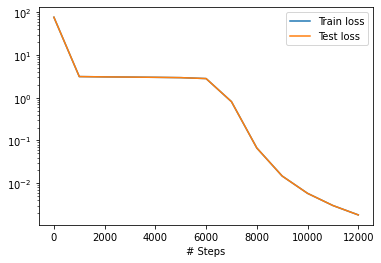

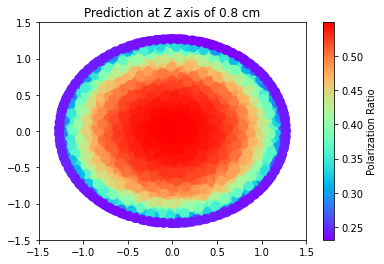

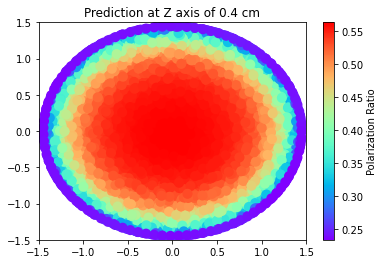

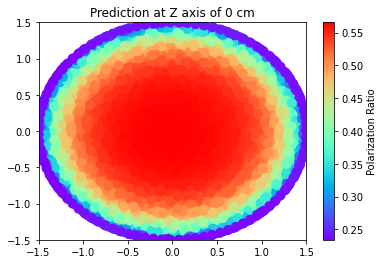

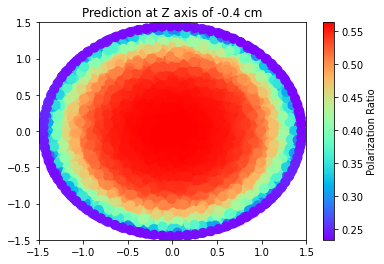

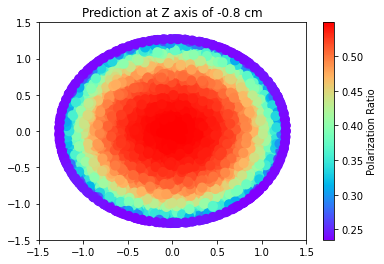

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 21 20:38:19 2022
Rop均匀时的实验，COMSOL和PINNs相互比较。注意事项：采样均匀性，绘图好不好看
@author: Administrator
"""

"""Backend supported: tensorflow.compat.v1"""
import deepxde as dde
import numpy as np
from deepxde.backend import tf
from scipy.special import gamma

#import mayavi.mlab as mlab
import matplotlib.pyplot as plt

from draw_counter import random_sphere_points, uniform_sample_points
from PIL import Image

## define parameters
D = 0.58 ## 扩散系数，cm2/s
Rop = 40
#Rrel = 17.5573
Rsd = 17.5573
Rwall = 2.564
q = 5 ## 减速因子
rcell = 1.5


# def fpde(x, y, int_mat):
#     """\int_theta D_theta^alpha u(x)"""
#     if isinstance(int_mat, (list, tuple)) and len(int_mat) == 3:
#         int_mat = tf.SparseTensor(*int_mat)
#         lhs = tf.sparse_tensor_dense_matmul(int_mat, y)
#     else:
#         lhs = tf.matmul(int_mat, y)
#     lhs = lhs[:, 0]
#     lhs *= gamma((1 - alpha) / 2) * gamma((3 + alpha) / 2) / (2 * np.pi ** 2)
#     x = x[: tf.size(lhs)]
#     rhs = (
#         2 ** alpha
#         * gamma(2 + alpha / 2)
#         * gamma((3 + alpha) / 2)
#         / gamma(3 / 2)
#         * (1 - (1 + alpha / 3) * tf.reduce_sum(x ** 2, axis=1))
#     )
#     return lhs - rhs

def bloch_pde(x_in, y_in):
    ''' x_in: (x,y,z) axis
        y_in: Pz polarization
    '''
    x = x_in[:, 0:1]
    y = x_in[:, 1:2]
    z = x_in[:, 2:3]
    
    dy_xx = dde.grad.hessian(y_in, x_in, i=0, j=0)
    dy_yy = dde.grad.hessian(y_in, x_in, i=1, j=1)
    dy_zz = dde.grad.hessian(y_in, x_in, i=2, j=2) # dy/dxidxj
    
    return -D*(dy_xx+dy_yy+dy_zz) + ((Rop+Rsd)/q+Rwall)*y_in - Rop/q

# def func(x):
#     return (np.abs(1 - np.linalg.norm(x, axis=1, keepdims=True) ** 2)) ** (
#         1 + alpha / 2
#     )

def func_boundary(x_in, Pz, numpy_X):
    x = x_in[:, 0:1]
    y = x_in[:, 1:2]
    z = x_in[:, 2:3]
    
    dPz_x = dde.grad.jacobian(Pz, x_in, i=0, j=0) # This is right
    dPz_y = dde.grad.jacobian(Pz, x_in, i=0, j=1)
    dPz_z = dde.grad.jacobian(Pz, x_in, i=0, j=2)
    
    return D/rcell*(x*dPz_x + y*dPz_y + z*dPz_z) + Pz*np.sqrt(1/2*np.abs(Rop*D))

geom = dde.geometry.Sphere([0, 0, 0], rcell)
#bc = dde.icbc.DirichletBC(geom, func_boundary, lambda _, on_boundary: on_boundary)

#bc = dde.icbc.RobinBC(geom, func_boundary, lambda _, on_boundary: on_boundary)
bc = dde.icbc.OperatorBC(geom, func_boundary, lambda _, on_boundary: on_boundary) # 函数调研下，operatorBC

# data = dde.data.FPDE(
#     geom,
#     fpde,
#     alpha,
#     bc,
#     [8, 8, 100],
#     num_domain=256,
#     num_boundary=1,
#     solution=func,
# )

data = dde.data.PDE(geom, bloch_pde, bc, num_domain=25000, num_boundary=3000)

net = dde.nn.FNN([3] + [30] * 4 + [1], "tanh", "Glorot normal")
# net.apply_output_transform(
#     lambda x, y: (1 - tf.reduce_sum(x ** 2, axis=1, keepdims=True)) * y
# )

model = dde.Model(data, net)
model.compile("adam", lr=1e-4)
#losshistory, train_state = model.train(epochs=8000, model_save_path='Bloch_Rop_v1')
losshistory, train_state = model.train(epochs=12000, model_save_path='./ckpt/Rop_v1')
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


#z_axis_list = [1.2, 0.8, 0.4, -0.4, -0.8, -1.2]
z_axis_list = [0.8, 0.4, 0, -0.4, -0.8]
for z_axis in z_axis_list:
    figure = plt.figure() 
    X = random_sphere_points(z= z_axis)
    y_pred = model.predict(X)[:, 0]
    np.save('./result/axes_{}'.format(z_axis), X)
    np.save('./result/pred_{}'.format(z_axis), y_pred)
    
    x_axis, y_axis = X[:, 0], X[:, 1]
    plt.scatter(x_axis, y_axis, s=50, c= y_pred, cmap='rainbow', linewidth=3)
    plt.colorbar(label="Polarization Ratio") 
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.title('Prediction at Z axis of {0} cm'.format(z_axis))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random


rcell = 1.5
sample_num = 200

def polar_sphere_points(z, sample_num = 200):
    radius_z = np.sqrt(rcell**2 - z**2)
    sample_data = []    
    
    for theta in np.linspace(0, 2*np.pi, sample_num):
        for r in np.linspace(0, radius_z, sample_num):
            x = r * np.cos(theta)
            y = r * np.sin(theta)
            sample_data.append((x, y, z)) # 200*200 = 40000个采样点
        
    sample_data = np.asarray(sample_data, dtype=np.float32
                            )
    return sample_data



C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


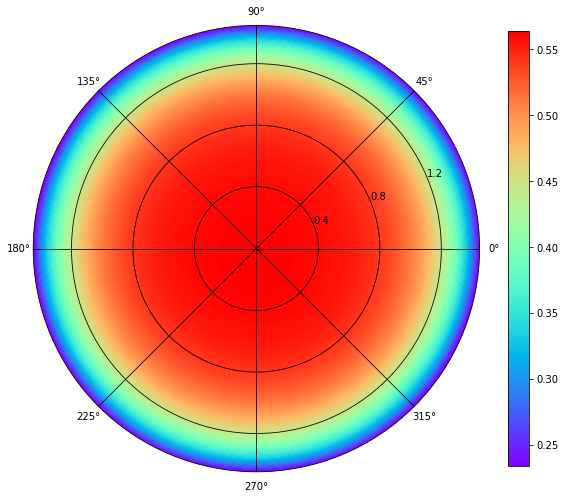

In [20]:
#x, y = X_data[:, 0], X_data[:, 1]
sample_num = 200
z = 0.4
radius_z = np.sqrt(rcell**2 - z**2)
X = polar_sphere_points(z= 0.4)
x = X[:, 0]
y_pred = model.predict(X)[:, 0]


y_pred_matrix = np.reshape(y_pred, (sample_num, sample_num))
theta_sequence = np.linspace(0, 2*np.pi, sample_num)
r_sequence = np.linspace(0, radius_z, sample_num)

plt.figure(figsize=(10, 10))
ax = plt.subplot(projection='polar')

##  角度、位置，顺序是不是对的呢？
#pc = ax.pcolor(theta_sequence, r_sequence, Pz_grid_mean, shading='auto', cmap='jet')
pc = ax.pcolor(theta_sequence, r_sequence, y_pred_matrix.T, shading='auto', cmap='rainbow')
plt.grid(c='black')
#ax.grid(False)
ax.set_rgrids([])
#ax.set_thetagrids(np.arange(0.0, 360.0, 30.0))
#ax.grid('True')
# vmin=1.46, vmax=1.8

ax.set_rgrids([0.4, 0.8, 1.2])
#plt.grid(c='black')
#plt.colorbar(pc, shrink=.8)
plt.colorbar(pc, shrink=.8)

file_name = './result/test.png'
plt.savefig(file_name, dpi=300)
plt.show()




C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


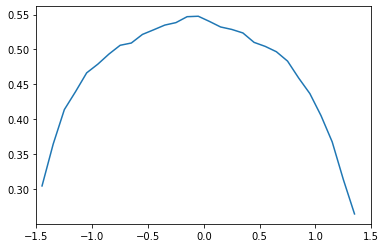

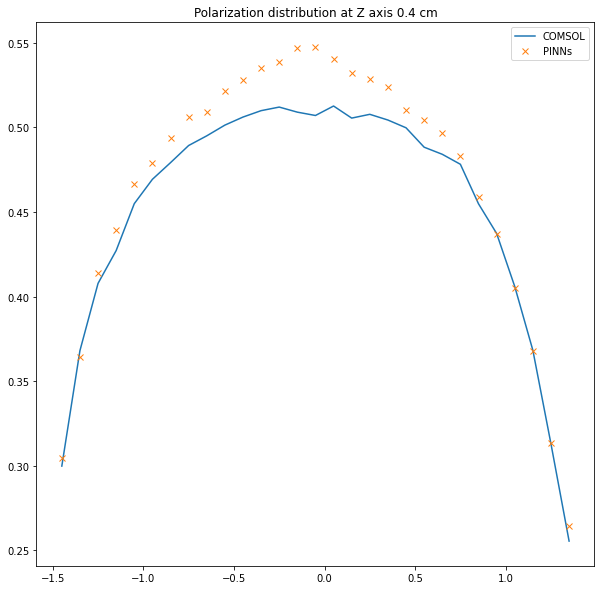

<Figure size 432x288 with 0 Axes>

In [12]:
# # -*- coding: utf-8 -*-
# """
# Created on Mon Mar 28 16:45:06 2022

# @author: Administrator
# 绘制对比图
# """

# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# file_idx = '0.4'
# filename = './result/COMSOL_Rop_40/z{0}.csv'.format(file_idx)
# df = pd.read_csv(filename, header=9, names=['x', 'y', 'z', 'Pz'])
# ## (x, y, z) u1, 20796*4

# x = np.asarray(df['x'])
# y = np.asarray(df['y'])
# z = np.asarray(df['z'])
# Pz = np.asarray(df['Pz'])

# ## 放到区间下，
# num_space = 30
# X_lim = np.linspace(-1.5, 1.5, num_space+1)
# x_space = 3/num_space
# Pz_dist_comsol = np.zeros(num_space) ## Pz value add
# Pz_space_num = np.zeros(num_space) ## Pz number

# for x_idx in range(len(x)):
#       Pz_idx = int((x[x_idx]+1.5)/x_space-1)
#       Pz_dist_comsol[Pz_idx] += Pz[x_idx]
#       Pz_space_num[Pz_idx] += 1
 
# Pz_density_p = Pz_dist_comsol/Pz_space_num      
# x_plot = (X_lim+x_space/2)[:-1]
# p_plot = Pz_density_p
# np.savez('./result/COMSOL_Rop_40/Z{0}'.format(file_idx), x_axis = x_plot, polarization=p_plot)
# plt.figure()      
# plt.plot((X_lim+x_space/2)[:-1], Pz_density)
# plt.xlim(-1.5, 1.5)
# plt.show()        



# location = '0.4'
# COMSOL_result_path = './result/COMSOL_Rop_40/Z{0}.npz'.format(location)
# #pred_result_path = './draw_figures/Z{0}_pred.npz'.format(location)

# COMSOL_data = np.load(COMSOL_result_path)
# #pred_data = np.load(pred_result_path)



# comsol_x = COMSOL_data['x_axis']
# comsol_p = COMSOL_data['polarization']

# #pred_x = pred_data['x_axis']
# #pred_p = pred_data['polarization']

# plt.figure(figsize=(10,10))
# plt.plot(comsol_x, comsol_p, label='COMSOL')
# ## 绘制Pz_density的数据，上个单元格的结果
# plt.plot(comsol_x, Pz_density, marker='x', linestyle='', label='PINNs')
# plt.title('Polarization distribution at Z axis {0} cm'.format(location))
# plt.legend()
# plt.show()
# plt.savefig('./draw_figures/polarization_dist_z_{0}.png'.format(location), dpi=320)



In [4]:
# z_axis_list = [0.8, 0.4, 0, -0.4, -0.8]
# for z_axis in z_axis_list:
#     figure = plt.figure() 
#     X = random_sphere_points(z= z_axis)
#     y_pred = model.predict(X)[:, 0]
#     np.save('./result/axes_{}'.format(z_axis), X)
#     np.save('./result/pred_{}'.format(z_axis), y_pred)
    
#     x_axis, y_axis = X[:, 0], X[:, 1]
#     plt.scatter(x_axis, y_axis, s=50, c= y_pred, cmap='rainbow')
#     plt.colorbar(label="Polarization Ratio") 
#     plt.xlim(-1.5, 1.5)
#     plt.ylim(-1.5, 1.5)
#     plt.title('Prediction at Z axis of {0} cm'.format(z_axis))

In [5]:
# # -*- coding: utf-8 -*-
# """
# Created on Thu Mar 24 10:18:05 2022

# @author: leisir
# """

# import matplotlib.pyplot as plt
# import numpy as np
# from scipy import io

# X_data = np.load('axes.npy')
# z = np.load('pred.npy')#[:1000]

# x, y = X_data[:, 0], X_data[:, 1]


# ## 放到区间下，
# Pz = z
# num_space = 30
# X_lim = np.linspace(-1.5, 1.5, num_space+1)
# x_space = 3/num_space
# Pz_dist = np.zeros(num_space) ## Pz value add
# Pz_space_num = np.zeros(num_space) ## Pz number

# for x_idx in range(len(x)):
#       Pz_idx = int((x[x_idx]+1.5)/x_space-1)
#       Pz_dist[Pz_idx] += Pz[x_idx]
#       Pz_space_num[Pz_idx] += 1
 
# Pz_density = Pz_dist/Pz_space_num      
# plt.figure()      
# plt.plot((X_lim+x_space)[:-1], Pz_density)
# plt.xlim(-1.5, 1.5)
# plt.show()      


In [6]:
## 放到区间下，
# Pz = y_pred
# num_space = 30
# X_lim = np.linspace(-1.5, 1.5, num_space+1)
# x_space = 3/num_space
# Pz_dist = np.zeros(num_space) ## Pz value add
# Pz_space_num = np.zeros(num_space) ## Pz number

# for x_idx in range(len(x)):
#       Pz_idx = int((x[x_idx]+1.5)/x_space-1)
#       Pz_dist[Pz_idx] += Pz[x_idx]
#       Pz_space_num[Pz_idx] += 1

# Pz_density = Pz_dist/Pz_space_num  
# plt.figure()
# plt.plot(Pz_density)

11.51146